# ANN Final Project 
## Approach 2: Data Preprocessing of Sep Files
Goals: 
- To preprocess the data of the Sep files each and analyse them
- Normalize the data between 1 and 0
- Train the 2 layer LSTM model on the data
- Predict the values of the test data


In [184]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix


import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.utils import shuffle

### Loading the .csv training data set

### Insights from paper: 
- This ideal desired output, however, strongly restricts the potential
start/end samples and will result in a high loss when the
start/end of a step is not detected at the exact sample. This
will make the network hard to train. Therefore, we relax our
constraints on the desired sequence by making the desired
output equal to one for some period around the true start/end
of a step.

In [185]:
# iterate through the folders in the data folder

persons = [i for i in range(2, 29)]
deleted_rows_begin = 0
deleted_rows_end = 0

drop_persons = []
for person in persons:
    # path to dataset folder
    folder_path = 'data/person_' + str(person)

    data_frames = []
    df_stepMixed = []

    # Loop through the files in the folder and load the data into a DataFrame

    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, header=0, names=[ 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z'])
            data_frames.append(df)
        if file.endswith('.csv.stepMixed'):
            step_labels_file_path = os.path.join(folder_path, file)
            step_labels_df = pd.read_csv(step_labels_file_path, header=None, names=['start_index', 'end_index'])
            df_stepMixed.append(step_labels_df)
            
    df_train = pd.concat(data_frames, axis=0, ignore_index=True)
    df_stepLabel = pd.concat(df_stepMixed, axis =0, ignore_index = True)

    #drop the column 'activity_id' from the df_train    
    #df_train = df_train.drop(['activity_id'], axis=1)

    # Feature engineering
    df_train['acc_magnitude'] = np.sqrt(df_train['accel_x']**2 + df_train['accel_y']**2 + df_train['accel_z']**2)
    df_train['gyro_magnitude'] = np.sqrt(df_train['gyro_x']**2 + df_train['gyro_y']**2 + df_train['gyro_z']**2)
    df_train.head()
    #df_stepLabel.head()

    df_train['start'] = 0
    df_train['end'] = 0
    
    
    # Loop through each row in df_stepLabel
    for _, row in df_stepLabel.iterrows():
        start_index = row['start_index']-1
        end_index = row['end_index']-1
        
        arbitary_k = 12
        for i in range(arbitary_k):
            df_train.loc[start_index+i, 'start'] = 1
            df_train.loc[end_index-i, 'end'] = 1
    
    # drop everything before the first step and after the last step of whole dataset
    first_step_start_index = df_stepLabel.iloc[0,0]
    last_step_end_index = df_stepLabel.iloc[-1,1]
    df_train_initial_shape = df_train.shape[0]
    df_train = df_train.iloc[first_step_start_index-1:last_step_end_index, :]
    
    print("Person: ", person)
    # statistics of the step_label column
    deleted_rows_begin += first_step_start_index-1
    print("Deleted rows from the beginning: ", first_step_start_index-1)
    print("Deleted rows from the end: ", df_train_initial_shape - last_step_end_index)
    deleted_rows_end += df_train_initial_shape - last_step_end_index


    print(df_train.shape)
    print(df_train['start'].value_counts())
    print(df_train['end'].value_counts())
    #get the correlation of of counts 
    series = df_train['start'].value_counts()
    print("Correlation between class 0 and 1: ", series[0]/series[1])
    if series[0]/series[1] > 4.5: # 6.0 is the threshold for the class imbalance
        print("!!!   Class imbalance    !!!")
        drop_persons.append(person)
        
    else:
        print("!!!   Class balance      !!!")
    print('\n')
    df_train.to_csv('data/person_labeled/person_labeled_'  + str(person) + '.csv', index=False)
print("All deleted rows from the beginning: ", deleted_rows_begin)
print("All deleted rows from the end: ",deleted_rows_end)




Person:  2
Deleted rows from the beginning:  556
Deleted rows from the end:  571
(22460, 10)
0    15260
1     7200
Name: start, dtype: int64
0    15260
1     7200
Name: end, dtype: int64
Correlation between class 0 and 1:  2.1194444444444445
!!!   Class balance      !!!


Person:  3
Deleted rows from the beginning:  731
Deleted rows from the end:  563
(30011, 10)
0    20987
1     9024
Name: start, dtype: int64
0    20987
1     9024
Name: end, dtype: int64
Correlation between class 0 and 1:  2.3256870567375887
!!!   Class balance      !!!


Person:  4
Deleted rows from the beginning:  842
Deleted rows from the end:  660
(19007, 10)
0    13703
1     5304
Name: start, dtype: int64
0    13703
1     5304
Name: end, dtype: int64
Correlation between class 0 and 1:  2.5835218702865763
!!!   Class balance      !!!


Person:  5
Deleted rows from the beginning:  2268
Deleted rows from the end:  616
(32171, 10)
0    23987
1     8184
Name: start, dtype: int64
0    23987
1     8184
Name: end, dtype:

### Here we see some dropped files due to data imbalance

In [186]:
print(drop_persons)

[]


### Here, I am checking the average IMU sample size for a single step. 

In [202]:
avg_sample_rate = []
# Loop through each row in df_stepLabel
for index, row in df_stepLabel.iterrows():
    start_index = row['start_index']
    end_index = row['end_index']
    # get the average sample counts for single step
    avg_sample_rate.append((end_index - start_index))
    
print('Mean:' , np.mean(avg_sample_rate), 'Std:', np.std(avg_sample_rate))


Mean: 53.042682926829265 Std: 9.107655992622494


Insights about sequence size: 
- The average step size is 44 samples, to set the same sequence lentgh include the whole step, although could be hard to detect start and end patterns. Sequences with 1 is a way more than the 0. 

- Check the balance between the 0 and 1. We want to have a balanced dataset, and so drop the high imbalanced files.

- Drop some persons above the threshold of imbalance and merge all the files...


In [203]:
persons = [i for i in range(2, 29)]
df_list = []
for person in persons:
    if person in drop_persons:
        print('Person {} dropped'.format(person))
        
    else:
        df = pd.read_csv('data/person_labeled/person_labeled_'  + str(person) + '.csv')
        df_list.append(df)
        print("Description for person: ", person)
        print(df.shape)
        

# Concatenate all dataframes in the df_list
df = pd.concat(df_list, axis=0, ignore_index=True)
print(df.start.value_counts())
df.to_csv('data/person_labeled_all.csv', index=False)


Description for person:  2
(22460, 10)
Description for person:  3
(30011, 10)


Description for person:  4
(19007, 10)
Description for person:  5
(32171, 10)
Description for person:  6
(24620, 10)
Description for person:  7
(48025, 10)
Description for person:  8
(28181, 10)
Description for person:  9
(31340, 10)
Description for person:  10
(10348, 10)
Description for person:  11
(24525, 10)
Description for person:  12
(32166, 10)
Description for person:  13
(38918, 10)
Description for person:  14
(15238, 10)
Description for person:  15
(24256, 10)
Description for person:  16
(26833, 10)
Description for person:  17
(18181, 10)
Description for person:  18
(21212, 10)
Description for person:  19
(9650, 10)
Description for person:  20
(24872, 10)
Description for person:  21
(13524, 10)
Description for person:  22
(27191, 10)
Description for person:  23
(38298, 10)
Description for person:  24
(14380, 10)
Description for person:  25
(19026, 10)
Description for person:  26
(18998, 10)
Description for person:  27
(19920, 10)
Description for person:  28
(22969, 10)
0    50

In [204]:
# Scaling the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df.iloc[:, :8] = scaler.fit_transform(df.iloc[:, :8])
df_np = df.to_numpy()


In [205]:
labels_data = df_np[:,8:10]
print('The shape of raw data: ', df_np.shape, labels_data.shape)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_np[:, :8], labels_data, test_size=0.2)
#Check the shape of the data
print('\nThe shape of splitted train data: ', train_data.shape, train_labels.shape)
print('The shape of splitted test data:' , test_data.shape, test_labels.shape)

The shape of raw data:  (656320, 10) (656320, 2)



The shape of splitted train data:  (525056, 8) (525056, 2)
The shape of splitted test data: (131264, 8) (131264, 2)


## We have here two choiches to make: 
1. Window sliding - where the windows are overlapped between the sequences 
2. Frangmentation - where each fragment is a completely separate chunk of the data 

TODO: experiment it and see what works best... we go here with **Fragmentation**

In [206]:
# Define fragment size
fragment_size = 100  # adjust this value as needed

# Function to split data into fragments
def create_fragments(data, labels, fragment_size):
    data_fragments = []
    label_fragments = []
    for i in range(0, len(data) - fragment_size + 1, fragment_size):
        data_fragments.append(data[i:i + fragment_size])
        label_fragments.append(labels[i:i + fragment_size])
    return np.array(data_fragments), np.array(label_fragments)

# Create fragments
train_data, train_labels = create_fragments(train_data, train_labels, fragment_size)
test_data, test_labels = create_fragments(test_data, test_labels, fragment_size)

#check once shape of the data after fragmenting
print('The shape of the train data after fragmenting:',train_data.shape, train_labels.shape)
print('The shape of the test data after fragmenting:', test_data.shape, test_labels.shape)

The shape of the train data after fragmenting: (5250, 100, 8) (5250, 100, 2)
The shape of the test data after fragmenting: (1312, 100, 8) (1312, 100, 2)


In [207]:
# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# Convert data to tensors
train_data_tensor = torch.Tensor(train_data).to(device)
test_data_tensor = torch.Tensor(test_data).to(device)
train_labels_tensor = torch.Tensor(train_labels).to(device)
test_labels_tensor = torch.Tensor(test_labels).to(device)


# Create TensorDatasets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)


# Define a batch size
batch_size = 400  
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



cuda


In [208]:
# Counting classes in train_labels_tensor
train_class_counts = train_labels_tensor.sum(dim=(0,1))
# Counting classes in test_labels_tensor
test_class_counts = test_labels_tensor.sum(dim=(0,1))

# Printing class counts
print('Train set:')
for i, count in enumerate(train_class_counts):
    print(f'Count of class {i}: {count.item()}')

print('\nTest set:')
for i, count in enumerate(test_class_counts):
    print(f'Count of class {i}: {count.item()}')


Train set:
Count of class 0: 119089.0
Count of class 1: 119006.0

Test set:
Count of class 0: 29711.0
Count of class 1: 29789.0


In [209]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size,dropout_rate1 , dropout_rate2 ):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.input_size = input_size
        self.lstm1 = nn.LSTM(input_size, hidden_layer_size, batch_first=True ) # batch_first=True means that the first dimension of the input and output will be the batch_size
        self.dropout1 = nn.Dropout(dropout_rate1) # to avoid overfitting
        self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size, batch_first=True) 
        self.dropout2 = nn.Dropout(dropout_rate2) 
        self.dense = nn.Linear(hidden_layer_size, output_size) # output layer
        self.sigmoid = nn.Sigmoid() # sigmoid activation function

    def forward(self, input_seq):
        lstm_out, _ = self.lstm1(input_seq.view(len(input_seq), -1, self.input_size)) # view() method is used to reshape the tensor
        lstm_out = self.dropout1(lstm_out) # to avoid overfitting
        lstm_out, _ = self.lstm2(lstm_out) # _ means that the hidden state is returned
        lstm_out = self.dropout2(lstm_out) 
        predictions = self.sigmoid(self.dense(lstm_out)) # dense layer
        return predictions


### Here we are going to train the model with some hyper-parameters


In [195]:
# Define a batch size
batch_size = 400  
input_size = 8
hidden_size = 64
output_size = 2 # Change to match the number of output classes
num_epochs = 100
learning_rate = 0.001
dropout_rate1 = 0.01
dropout_rate2 = 0.2

model = LSTM(input_size, hidden_size, output_size, dropout_rate1, dropout_rate2).to(device)


# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

# Define number of epochs
num_epochs = 10  # adjust this value as needed

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    if (epoch+1) % 10 == 0:
      # Evaluate the model
      model.eval()

      with torch.no_grad():
          for data in test_loader:
              inputs, labels = data
              outputs = model(inputs)
              # Apply threshold
              outputs = (outputs > 0.5).float()
              correct = (outputs == labels).sum().item()
              total = labels.size(0)*labels.size(1) *labels.size(2)
              print(f'Torch accuracy: {correct/total:.4f}')

          model.train()

print('Finished Training')


Epoch 10/100, Loss: 0.5415272116661072
Torch accuracy: 0.7722
Torch accuracy: 0.7723
Torch accuracy: 0.7732
Torch accuracy: 0.7739
Epoch 20/100, Loss: 0.538972020149231
Torch accuracy: 0.7722
Torch accuracy: 0.7723
Torch accuracy: 0.7732
Torch accuracy: 0.7739
Epoch 30/100, Loss: 0.5064778923988342
Torch accuracy: 0.7733
Torch accuracy: 0.7738
Torch accuracy: 0.7747
Torch accuracy: 0.7762
Epoch 40/100, Loss: 0.48188596963882446
Torch accuracy: 0.7912
Torch accuracy: 0.7890
Torch accuracy: 0.7907
Torch accuracy: 0.7944
Epoch 50/100, Loss: 0.47528818249702454
Torch accuracy: 0.7941
Torch accuracy: 0.7918
Torch accuracy: 0.7925
Torch accuracy: 0.7967
Epoch 60/100, Loss: 0.4721463620662689
Torch accuracy: 0.7949
Torch accuracy: 0.7928
Torch accuracy: 0.7935
Torch accuracy: 0.7975
Epoch 70/100, Loss: 0.47038984298706055
Torch accuracy: 0.7952
Torch accuracy: 0.7936
Torch accuracy: 0.7942
Torch accuracy: 0.7980
Epoch 80/100, Loss: 0.4678933620452881
Torch accuracy: 0.7961
Torch accuracy: 0.7

## Training of Network with different Learning Rates

Training with learning rate: 0.1
Epoch 10/100, Loss: 0.5354201240198952
Torch accuracy: 0.7727
Epoch 20/100, Loss: 0.5354280854974475
Torch accuracy: 0.7727
Epoch 30/100, Loss: 0.5351542489869254
Torch accuracy: 0.7727
Epoch 40/100, Loss: 0.5350318551063538
Torch accuracy: 0.7727
Epoch 50/100, Loss: 0.5350263459341866
Torch accuracy: 0.7727
Epoch 60/100, Loss: 0.534890672990254
Torch accuracy: 0.7727
Epoch 70/100, Loss: 0.5348377483231681
Torch accuracy: 0.7727
Epoch 80/100, Loss: 0.5347993501595089
Torch accuracy: 0.7727
Epoch 90/100, Loss: 0.531284728220531
Torch accuracy: 0.7727
Epoch 100/100, Loss: 0.5258111996310098
Torch accuracy: 0.7727
Training with learning rate: 0.01
Epoch 10/100, Loss: 0.5145772440092904
Torch accuracy: 0.7727
Epoch 20/100, Loss: 0.4592147703681673
Torch accuracy: 0.7950
Epoch 30/100, Loss: 0.4524177312850952
Torch accuracy: 0.7969
Epoch 40/100, Loss: 0.4469464612858636
Torch accuracy: 0.7986
Epoch 50/100, Loss: 0.44096985885075163
Torch accuracy: 0.7997
Epo

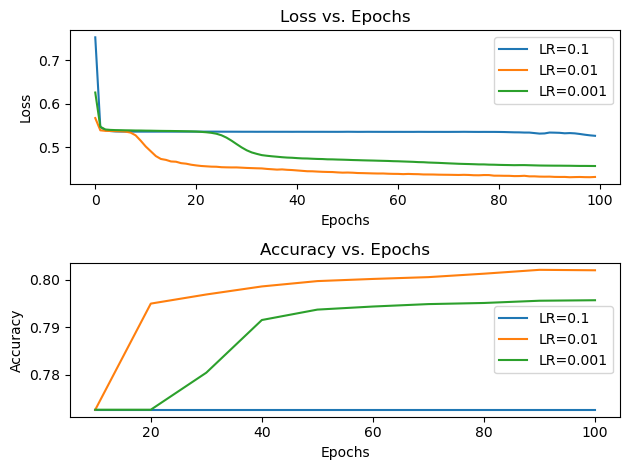

In [196]:
# Define learning rates
learning_rates = [0.1, 0.01, 0.001]

# Store results
losses = {}
accuracies = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = LSTM(input_size, hidden_size, output_size, dropout_rate1, dropout_rate2).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr)

    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        epoch_losses.append(running_loss/len(train_loader))
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_losses[-1]}')
            
            model.eval()
            correct = 0
            total = 0
            
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data
                    outputs = model(inputs)
                    outputs = (outputs > 0.5).float()
                    correct += (outputs == labels).sum().item()
                    total += labels.size(0)*labels.size(1)*labels.size(2)
                    
                accuracy = correct/total
                print(f'Torch accuracy: {accuracy:.4f}')
                epoch_accuracies.append(accuracy)
                
            model.train()
    
    losses[lr] = epoch_losses
    accuracies[lr] = epoch_accuracies

# Plotting
fig, axs = plt.subplots(2)

for lr in learning_rates:
    axs[0].plot(range(num_epochs), losses[lr], label=f"LR={lr}")
    axs[1].plot(range(10, num_epochs + 1, 10), accuracies[lr], label=f"LR={lr}")

axs[0].set_title('Loss vs. Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Accuracy vs. Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


The above graph show the model train and test accuracies of the LSTM model with different learning rates.

learning rate = 0.1
- The train lost is almost constant all the time starting. The accuracy is almost 80% all time for all 10x10 epochs.


learning rate = 0.01
- The training accuracy is increasing from 77% to 80%, which is a good sign.  The model is not overfitting and the model is learning the data well.


learning rate = 0.001
- The training accuracy is increased from starting 77% only till 79%. Altough it is good sign that showing the model is learning the data well, however learning rate with 0.01 is showing better results. 

Our LSTM 2 layers with dense with the learning rate 0.01 showed good amount of accuracy in both training and test accuracies compared to the other learning rates.

### Training the network with different Hidden Sizes

Training with hidden sizes: 32
Epoch 10/20, Loss: 0.509151462997709
Torch accuracy: 0.7733
Epoch 20/20, Loss: 0.46505857365471975
Torch accuracy: 0.7954
Training with hidden sizes: 64
Epoch 10/20, Loss: 0.515650966337749
Torch accuracy: 0.7732
Epoch 20/20, Loss: 0.4671450917209898
Torch accuracy: 0.7960
Training with hidden sizes: 128
Epoch 10/20, Loss: 0.5055205800703594
Torch accuracy: 0.7809
Epoch 20/20, Loss: 0.46145445108413696
Torch accuracy: 0.7950
Training with hidden sizes: 256
Epoch 10/20, Loss: 0.48228299617767334
Torch accuracy: 0.7921
Epoch 20/20, Loss: 0.46391502022743225
Torch accuracy: 0.7957


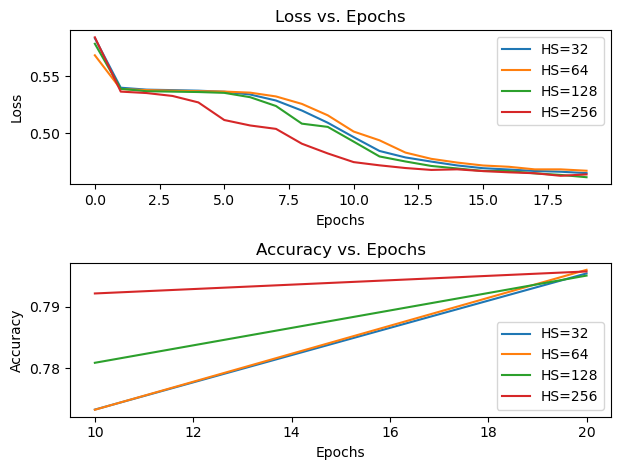

In [215]:

hidden_sizes_set = [32, 64, 128, 256]

# Store results
losses = {}
accuracies = {}
# Define a batch size
batch_size = 400  # depending on GPU memory size
input_size = 8

output_size = 2 # Change to match the number of output classes
num_epochs = 20
learning_rate = 0.01
dropout_rate1 = 0.01
dropout_rate2 = 0.2


for hidden_sizes in hidden_sizes_set:
    print(f"Training with hidden sizes: {hidden_sizes}")
    model = LSTM(input_size, hidden_sizes, output_size, dropout_rate1, dropout_rate2).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), learning_rate)

    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        epoch_losses.append(running_loss/len(train_loader))
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_losses[-1]}')
            
            model.eval()
            correct = 0
            total = 0
            
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data
                    outputs = model(inputs)
                    outputs = (outputs > 0.5).float()
                    correct += (outputs == labels).sum().item()
                    total += labels.size(0)*labels.size(1)*labels.size(2)
                    
                accuracy = correct/total
                print(f'Torch accuracy: {accuracy:.4f}')
                epoch_accuracies.append(accuracy)
                
            model.train()
    
    losses[str(hidden_sizes)] = epoch_losses
    accuracies[str(hidden_sizes)] = epoch_accuracies

# Plotting
fig, axs = plt.subplots(2)

for hidden_sizes in hidden_sizes_set:
    axs[0].plot(range(num_epochs), losses[str(hidden_sizes)], label=f"HS={hidden_sizes}")
    axs[1].plot(range(10, num_epochs + 1, 10), accuracies[str(hidden_sizes)], label=f"HS={hidden_sizes}")

axs[0].set_title('Loss vs. Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Accuracy vs. Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


Insights about hidden size: 
- From the plots it is obviuos that the hidden size of 256 is performing better than the other hidden sizes. Generally saying, higher the hidden size, better the performance. However, it is not always true.


tensor([0.2436, 0.2546], device='cuda:0')
torch.Size([40000, 2])
torch.Size([40000, 2])
tensor([0.1008, 0.1632], device='cuda:0')
torch.Size([40000, 2])
torch.Size([40000, 2])
tensor([0.1665, 0.2136], device='cuda:0')
torch.Size([40000, 2])
torch.Size([40000, 2])
tensor([0.0934, 0.1591], device='cuda:0')
torch.Size([11200, 2])
torch.Size([11200, 2])
131200 131200


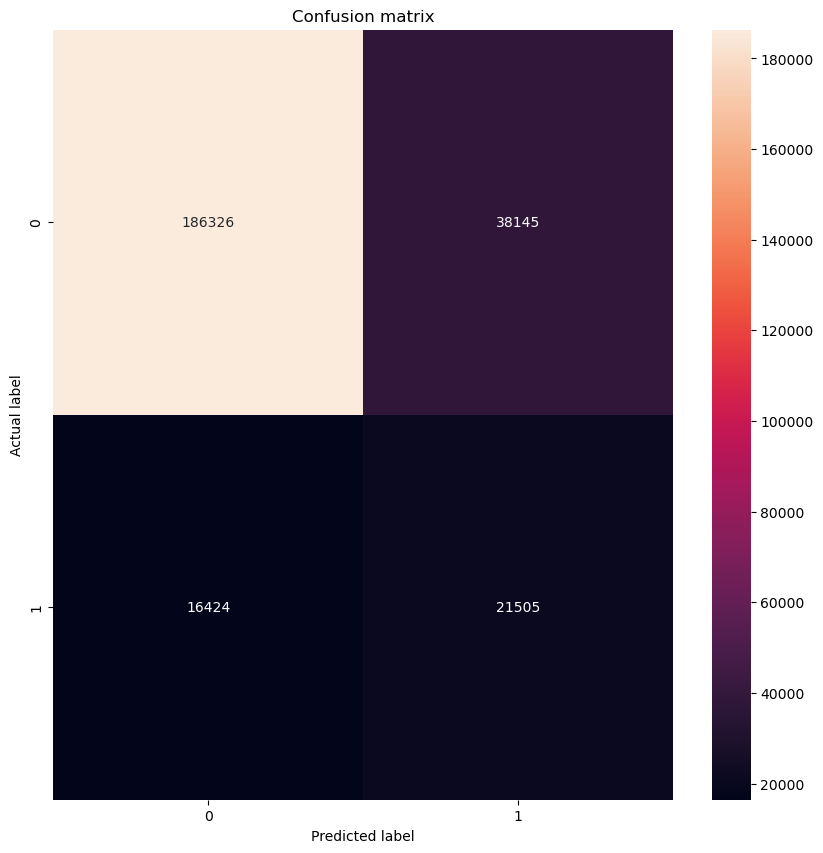

In [200]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for data in test_loader:  # use test_loader here
        inputs, labels = data
        outputs = model(inputs)
        # reshape the outputs to 2D array [batch_sizefragment_size, 2]
        outputs = outputs.view(-1, 2)
        #outputs = outputs.view(-1)
        print(outputs[0])
        predicted = (outputs > 0.4).float() # get the index of the class with maximum probability
        print(predicted.shape)
        all_predictions.extend(predicted.cpu().numpy().astype(int))  # Move prediction to CPU for use with sklearn
        # reshape the labels to 2D array [batch_sizefragment_size, 1]
        labels = labels.view(-1, 2)
        print(labels.shape)
        all_labels.extend(labels.cpu().numpy())  # Move labels to CPU for use with sklearn
print(len(all_predictions),len(all_labels))

# flatten the list of predictions and labels
all_predictions_flat = [item for sublist in all_predictions for item in sublist]
all_labels_flat = [item for sublist in all_labels for item in sublist]
cm = confusion_matrix(all_predictions_flat, all_labels_flat)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()


### Labelling the test dataset 
- test dataset also scaled and added two more features to make it same as the training dataset
- depending on GPU memory, batch size can be used


In [198]:
test_path = 'data/testdata.csv'

# Load data from csv file into a DataFrame
df_test = pd.read_csv(test_path, header=0, names=[ 'AccelX_5', 'AccelY_5', 'AccelZ_5', 'GyroX_5', 'GyroY_5', 'GyroZ_5'])
# Feature engineering
df_test['acc_magnitude'] = np.sqrt(df_test['AccelX_5']**2 + df_test['AccelY_5']**2 + df_test['AccelZ_5']**2)
df_test['gyro_magnitude'] = np.sqrt(df_test['GyroX_5']**2 + df_test['GyroY_5']**2 + df_test['GyroZ_5']**2)

#print(df_test.head())
#print(df_test.shape)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
test_np = scaler.fit_transform(df_test)

# reshape test_np to (N,1,8)
#test_np = test_np.reshape(-1,1,8)
# Define fragment size
fragment_size = 1  # adjust this value as needed
#test_np = create_fragments_data(test_np, test_np, fragment_size)


test_data_tensor_1 = torch.Tensor(test_np).to(device)
un_test_dataset = TensorDataset(test_data_tensor_1, test_data_tensor_1)

# Define a batch size
batch_size = 100  
# Create DataLoaders
un_test_loader = DataLoader(un_test_dataset, batch_size=batch_size, shuffle=True)


# Create a DataFrame with 'index', 'start' and 'end' columns
df_test_results = pd.DataFrame({
    'index': np.arange(len(df_test)),
    'start': np.zeros(len(df_test)),  # Initialize with zeros
    'end': np.zeros(len(df_test)),    # Initialize with zeros
})

# Evaluate the model
model.eval()
result = []
with torch.no_grad():
  for i,data in un_test_loader:
    test_data = data
    predictions = model(test_data)
    predicted = predictions.cpu().numpy()
    # save the predicted values to the result list
    result.extend(predicted)
    
result = np.array(result)   

for i in range(len(test_np)):
  df_test_results.loc[i, 'start'] = result[i,0,0]
  df_test_results.loc[i, 'end'] = result[i,0,1]

df_test_results.head()

,index,start,end
0,0,0.686257,0.214827
1,1,0.701925,0.228126
2,2,0.678092,0.092418
3,3,0.707750,0.191803
4,4,0.500064,0.271137


In [199]:
# Function to split data into fragments
def create_fragments_data(data, labels, fragment_size):
    data_fragments = []
    for i in range(0, len(data) - fragment_size + 1, fragment_size):
        data_fragments.append(data[i:i + fragment_size])
        
    return np.array(data_fragments)